In [1]:
# 📦 Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


In [4]:
# 📥 Step 2: Load Dataset
# 📥 Step 2: Load Dataset
# Make sure these paths are correct after uploading the files
train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')

# Drop first column (Unnamed: 0 if present)
train_df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
test_df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

print(train_df.shape)
train_df.head()

(1296675, 22)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [15]:
# 🧹 Step 3: Preprocessing Function
def preprocess(df):
    df = df.copy()

    # Convert datetime
    # Check if the column exists before trying to convert it
    if 'trans_date_trans_time' in df.columns:
        df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

        # Extract datetime features only if the column exists
        df['hour'] = df['trans_date_trans_time'].dt.hour
        df['day'] = df['trans_date_trans_time'].dt.day
        df['month'] = df['trans_date_trans_time'].dt.month
        df['weekday'] = df['trans_date_trans_time'].dt.weekday

    # Label encode other categorical features
    le = LabelEncoder()
    # Exclude 'merchant' from label encoding
    cols_to_encode = ['category', 'gender', 'job', 'state', 'city']
    for col in cols_to_encode:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Drop unused columns, including 'merchant' and 'cc_num' (already dropped in Step 4 but good to be explicit here)
    # Ensure columns exist before dropping
    cols_to_drop = ['trans_date_trans_time', 'first', 'last', 'street', 'dob', 'merchant']
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True, errors='ignore')

    return df

# Apply preprocess function only once to each dataframe
# Removed duplicate calls to preprocess
train_df = preprocess(train_df)
test_df = preprocess(test_df)

# 🎯 Step 4: Split Features & Target
# Drop 'is_fraud' and 'cc_num'. merchant is now dropped in preprocess.
X_train = train_df.drop(['is_fraud', 'cc_num'], axis=1, errors='ignore') # Use errors='ignore' in case cc_num was already dropped in preprocess
y_train = train_df['is_fraud']

X_test = test_df.drop(['is_fraud', 'cc_num'], axis=1, errors='ignore') # Use errors='ignore'
y_test = test_df['is_fraud']

# 🤖 Step 5: Train Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    print(f"\n🔍 {name}")
    # Ensure column names are strings, which can sometimes cause issues with older sklearn versions or specific model implementations
    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)

    # Add this line to inspect the data types of X_train before fitting
    print("X_train dtypes:\n", X_train.dtypes)
    # Add this line to inspect the data types of X_test before fitting
    print("X_test dtypes:\n", X_test.dtypes)

    # Check for any columns with object dtype (which often indicates strings)
    object_cols_train = X_train.select_dtypes(include='object').columns
    object_cols_test = X_test.select_dtypes(include='object').columns
    print("Object columns in X_train:", object_cols_train)
    print("Object columns in X_test:", object_cols_test)

    # If any object columns are found, they need to be handled (dropped or encoded)
    # Based on the error and the preprocess function, the 'merchant' column might still be present.
    # Ensure 'merchant' or any other identified object columns are dropped if not already handled.
    cols_to_drop_before_train = list(object_cols_train) # or specific columns like ['merchant'] if identified
    X_train = X_train.drop(columns=cols_to_drop_before_train, errors='ignore')
    X_test = X_test.drop(columns=cols_to_drop_before_train, errors='ignore') # Drop same columns from test set

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", model.score(X_test, y_test))
    print("ROC-AUC:", roc_auc_score(y_test, proba))
    print("Classification Report:\n", classification_report(y_test, preds))


🔍 Logistic Regression
X_train dtypes:
 category        int64
amt           float64
gender          int64
city            int64
state           int64
zip             int64
lat           float64
long          float64
city_pop        int64
job             int64
trans_num      object
unix_time       int64
merch_lat     float64
merch_long    float64
hour            int32
day             int32
month           int32
weekday         int32
dtype: object
X_test dtypes:
 category        int64
amt           float64
gender          int64
city            int64
state           int64
zip             int64
lat           float64
long          float64
city_pop        int64
job             int64
trans_num      object
unix_time       int64
merch_lat     float64
merch_long    float64
hour            int32
day             int32
month           int32
weekday         int32
dtype: object
Object columns in X_train: Index(['trans_num'], dtype='object')
Object columns in X_test: Index(['trans_num'], dtype='object

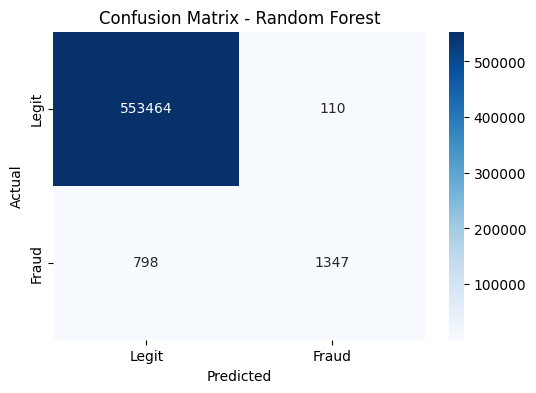

In [16]:
# 📊 Step 6: Confusion Matrix Heatmap for Random Forest
rf_model = models['Random Forest']
rf_preds = rf_model.predict(X_test)

cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


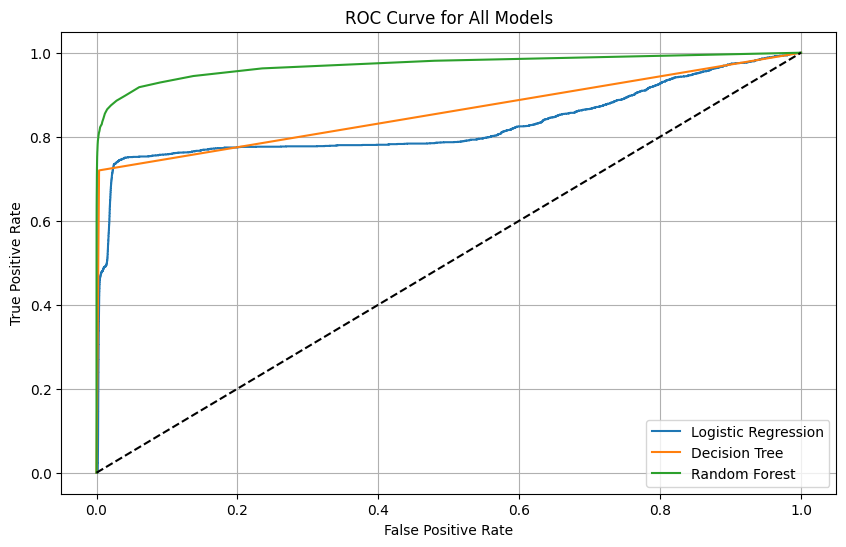

In [17]:
# 📈 Step 7: ROC Curves
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models")
plt.legend()
plt.grid()
plt.show()


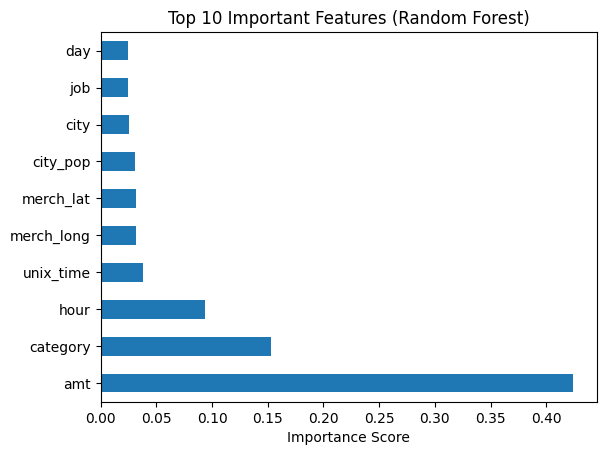

In [18]:
# 🌟 Step 8: Feature Importance (Random Forest)
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.show()
